## Librairies versions

In [67]:
#!pip install -r requirements.txt

In [58]:
#!python --version
#3.11.11

In [4]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import arff
import matplotlib.pyplot as plt
import seaborn as sns

## 1) RESUME DE L'ETUDE

Cette étude utilise des données de télédétection haute résolution (Quickbird) pour détecter des arbres malades dans des images satellites. Le dataset contient des segments d'images, chacun associé à des informations spectrales (bande verte, rouge, proche infrarouge) et texturales (bande panchromatique). Les deux classes d'observations sont : **arbres malades** et **autres couvertures terrestres**. L'objectif est de prédire la présence de maladies chez les arbres en se basant sur des caractéristiques spectrales et texturales, telles que la texture de l'image (GLCM_Pan) et les moyennes des différentes bandes (vert, rouge, NIR).


lien de la bdd : https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfInstances=between_1000_10000&qualities.NumberOfFeatures=lte_10&id=40983

📌 Variables disponibles :

- **class** : Catégorie de l'observation  
  - `'1'` : Autres couvertures terrestres 
  - `'2'` : Arbres malades  

- **GLCM_Pan** : Moyenne de texture de la bande panchromatique (*GLCM = Matrice de cooccurrence des niveaux de gris*)  

- **Mean_G** : Moyenne de la valeur de la bande verte  

- **Mean_R** : Moyenne de la valeur de la bande rouge  

- **Mean_NIR** : Moyenne de la valeur de la bande proche infrarouge (*NIR*)  

- **SD_Pan** : Écart-type de la bande panchromatique  


## 2) ANALYSE DESCRIPTIVE

In [5]:
# IMPORTATION
with open("db_tree.arff", "r") as file:
    data = arff.load(file)

df = pd.DataFrame(data["data"], columns=[attr[0] for attr in data["attributes"]])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GLCM_Pan  4839 non-null   float64
 1   Mean_G    4839 non-null   float64
 2   Mean_R    4839 non-null   float64
 3   Mean_NIR  4839 non-null   float64
 4   SD_Plan   4839 non-null   float64
 5   class     4839 non-null   object 
dtypes: float64(5), object(1)
memory usage: 227.0+ KB
None


In [6]:
df["class"] = df["class"].astype(int)

In [7]:
df.head()

,GLCM_Pan,Mean_G,Mean_R,Mean_NIR,SD_Plan,class
0,120.362774,205.500000,119.395349,416.581395,20.676318,2
1,124.739583,202.800000,115.333333,354.333333,16.707151,2
2,134.691964,199.285714,116.857143,477.857143,22.496712,2
3,127.946309,178.368421,92.368421,278.473684,14.977453,2
4,135.431548,197.000000,112.690476,532.952381,17.604193,2


In [16]:
# VALEURS MANQUANTES
print(df.isna().sum())

GLCM_Pan    0
Mean_G      0
Mean_R      0
Mean_NIR    0
SD_Plan     0
class       0
dtype: int64


In [17]:
# STANDARDISATION
from sklearn.preprocessing import StandardScaler

float_columns = df.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
df[float_columns] = scaler.fit_transform(df[float_columns])

print(df.head())

   GLCM_Pan    Mean_G    Mean_R  Mean_NIR   SD_Plan  class
0 -0.482765 -0.409632  0.049840 -0.697603 -0.354813      2
1 -0.157331 -0.452314 -0.015678 -1.095194 -0.724868      2
2  0.582671 -0.507868  0.008900 -0.306223 -0.185094      2
3  0.081103 -0.838533 -0.386084 -1.579725 -0.886132      2
4  0.637662 -0.544001 -0.058305  0.045682 -0.641235      2


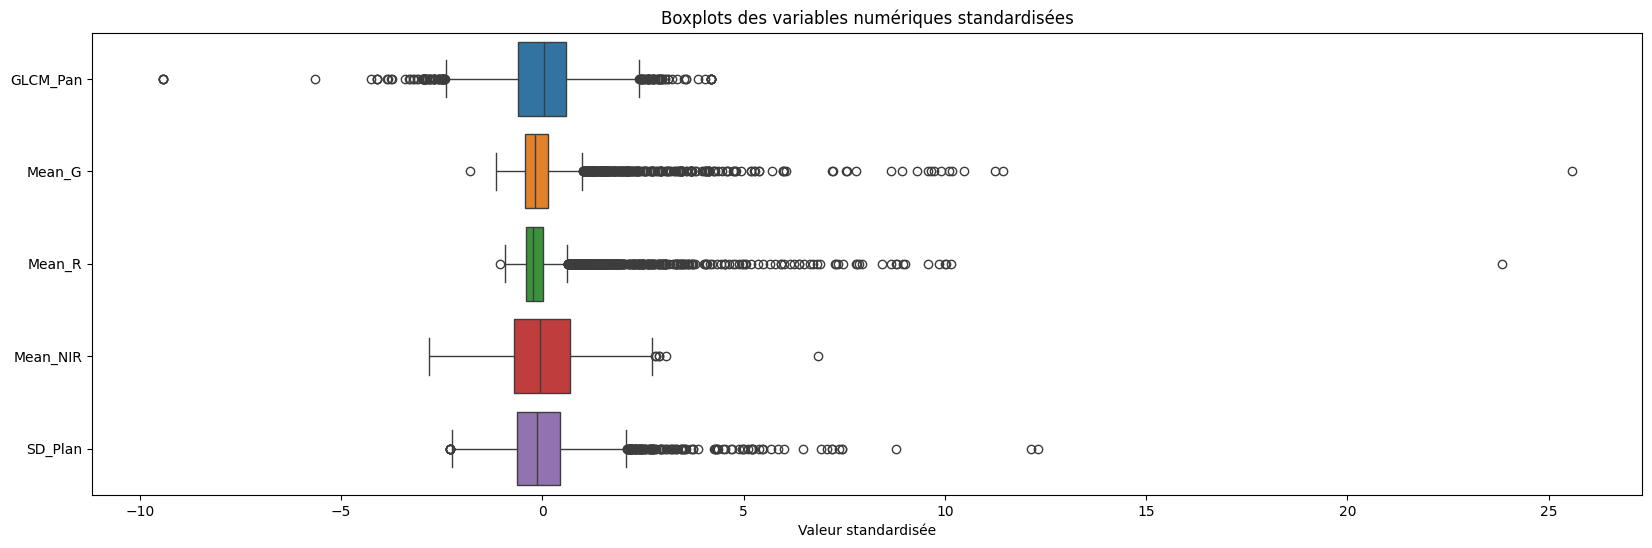

In [26]:
# OUTLIERS
plt.figure(figsize=(20, 6))
sns.boxplot(data=df[float_columns], orient='h')
plt.title('Boxplots des variables numériques standardisées')
plt.xlabel('Valeur standardisée')
plt.show()

Il y a l'air d'avoir une valeur vraiment aberrante dans mean_g et mean_r.

In [33]:
# Trouver la ligne où Mean_G est maximum
max_mean_g = df[df['Mean_G'] == df['Mean_G'].max()]
print("Ligne avec Mean_G maximum :")
print(max_mean_g)
# Trouver la ligne où Mean_R est maximum
max_mean_r = df[df['Mean_R'] == df['Mean_R'].max()]
print("Ligne avec Mean_R maximum :")
print(max_mean_r)

Ligne avec Mean_G maximum :
      GLCM_Pan     Mean_G     Mean_R  Mean_NIR   SD_Plan  class
4190 -0.759944  11.449888  10.018573  1.586214 -0.334095      1
Ligne avec Mean_R maximum :
      GLCM_Pan     Mean_G     Mean_R  Mean_NIR   SD_Plan  class
1030  -0.18289  10.463759  10.161871  2.596608  3.072194      1


In [32]:
# C'est la même observation : 4818. Je fais le choix de la supprimer pour ne pas biaiser les modèles à venir.
df = df.drop(index=4818).reset_index(drop=True)

In [34]:
# CORRELATION AVEC LA TARGET
df.corr()["class"].sort_values(ascending=False)

class       1.000000
GLCM_Pan    0.014848
Mean_R      0.002226
SD_Plan    -0.092945
Mean_G     -0.104694
Mean_NIR   -0.129472
Name: class, dtype: float64

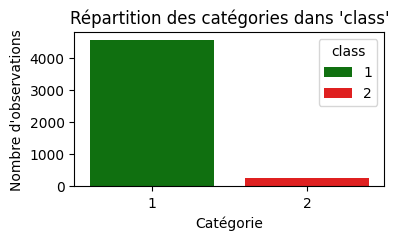

In [27]:
# REPARTITION DES CLASSES
plt.figure(figsize=(4, 2))
sns.countplot(x="class", data=df, hue="class", palette=["green", "red"])
plt.title("Répartition des catégories dans 'class'")
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'observations")
plt.show()

In [35]:
df["class"].value_counts()

1    4577
2     261
Name: class, dtype: int64

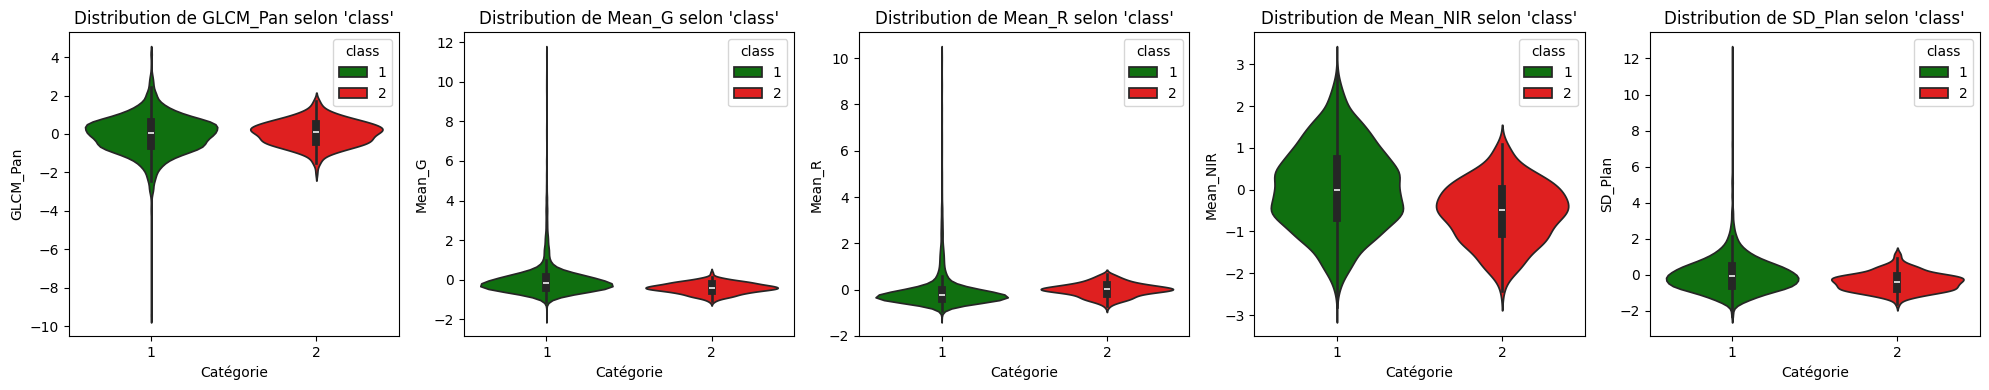

In [36]:
# REPARTITION CLASSES PAR VARIABLES
# Violin plot pour voir quelle variable sera un bon prédicteur dans les modèles

# Liste des variables à afficher
variables = ["GLCM_Pan", "Mean_G", "Mean_R", "Mean_NIR", "SD_Plan"]

# Création de la figure et des axes pour les subplots
fig, axes = plt.subplots(1, len(variables), figsize=(20, 4))  # 1 ligne, len(variables) colonnes

# Boucle pour créer un violin plot pour chaque variable
for i, var in enumerate(variables):
    sns.violinplot(x="class", y=var, data=df, hue="class", palette=["green", "red"], ax=axes[i])

    # Ajouter des titres et labels pour chaque subplot
    axes[i].set_title(f"Distribution de {var} selon 'class'")
    axes[i].set_xlabel("Catégorie")
    axes[i].set_ylabel(var)

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

Il reste difficile de désigner clairement la meilleure variable, mais Mean_NIR semble présenter le potentiel le plus prometteur pour discriminer les catégories.

## 3) MODELISATION

Nous avons constaté un fort déséquilibre des classes (95-5%). Si le modèle prédit systématiquement la classe majoritaire (classe 1), il affichera une précision de 95%, ce qui pourrait paraître satisfaisant, mais ce n’est pas ce que nous recherchons. Il est donc nécessaire de corriger ce problème. Pour cela, voici les deux solutions que nous allons utiliser :

- Dans les modèles Gradient Boosting et SVM, il existe un argument permettant d’attribuer un poids plus élevé à la classe minoritaire pendant l’entraînement, ce qui permet de mieux la prendre en compte (pour le GB, c'est déjà par défaut).

- Je vais appliquer l’oversampling avec SMOTE sur la classe minoritaire avant d’entraîner les modèles, afin d’équilibrer les classes.

### 1) class_weight

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Split des données
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["class"]), df["class"], random_state=42)

# Modèle Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Modèle SVM
svm_model = SVC(class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

----- Gradient Boosting Classifier -----
              precision    recall  f1-score   support

           1       0.98      1.00      0.99      1141
           2       0.96      0.72      0.83        69

    accuracy                           0.98      1210
   macro avg       0.97      0.86      0.91      1210
weighted avg       0.98      0.98      0.98      1210

Matrice de confusion - Gradient Boosting :


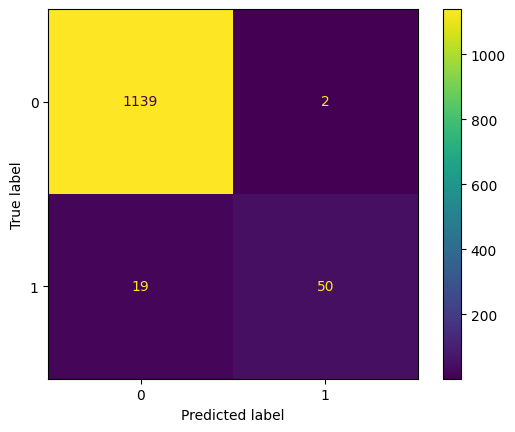

In [44]:
print("----- Gradient Boosting Classifier -----")
print(classification_report(y_test, y_pred_gb))

print("Matrice de confusion - Gradient Boosting :")
cm_gb = confusion_matrix(y_test, y_pred_gb)
ConfusionMatrixDisplay(cm_gb).plot()

----- SVM Classifier -----
              precision    recall  f1-score   support

           1       1.00      0.97      0.98      1141
           2       0.67      0.94      0.78        69

    accuracy                           0.97      1210
   macro avg       0.83      0.96      0.88      1210
weighted avg       0.98      0.97      0.97      1210

Matrice de confusion - SVM :


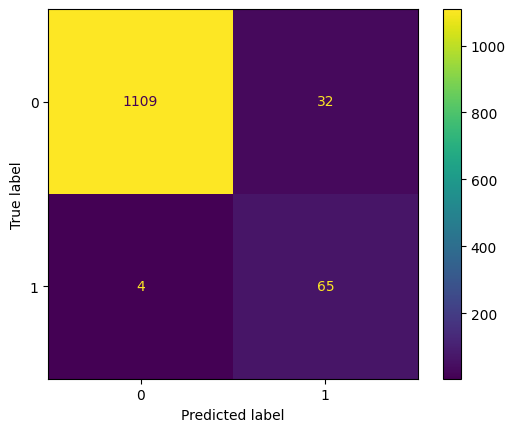

In [45]:
print("----- SVM Classifier -----")
print(classification_report(y_test, y_pred_svm))

print("Matrice de confusion - SVM :")
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot()

Le Gradient Boosting obtient de meilleurs résultats sur la classe 1, tandis que le SVM fait moins d'erreurs sur la classe 2. Il est donc difficile de départager les deux modèles.

### 2) SMOTE

In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Application de SMOTE uniquement sur le jeu d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Avant SMOTE :")
print(y_train.value_counts())
print("\nAprès SMOTE :")
print(y_train_resampled.value_counts())

Avant SMOTE :
1    3436
2     192
Name: class, dtype: int64

Après SMOTE :
1    3436
2    3436
Name: class, dtype: int64


In [69]:
# Gradient Boosting avec données SMOTE
gb_model_smote = GradientBoostingClassifier(random_state=42)
gb_model_smote.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model_smote.predict(X_test)

# SVM avec données SMOTE
svm_model_smote = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model_smote.fit(X_train_resampled, y_train_resampled)
svm_predictions = svm_model_smote.predict(X_test)

Résultats pour Gradient Boosting avec SMOTE :
              precision    recall  f1-score   support

           1       0.99      0.98      0.99      1141
           2       0.73      0.88      0.80        69

    accuracy                           0.98      1210
   macro avg       0.86      0.93      0.89      1210
weighted avg       0.98      0.98      0.98      1210

Matrice de confusion - Gradient Boosting SMOTE :


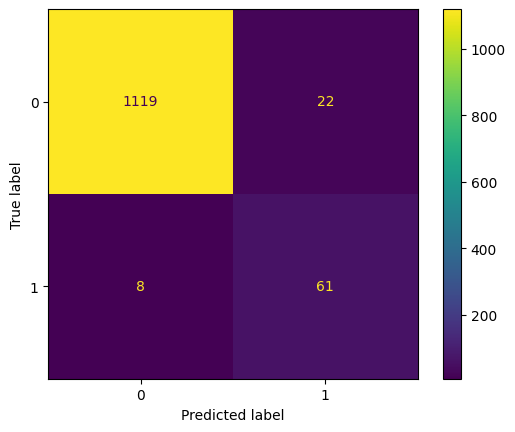

In [70]:
# --- Gradient Boosting après SMOTE ---
print("Résultats pour Gradient Boosting avec SMOTE :")
print(classification_report(y_test, gb_predictions))

cm_gb_smote = confusion_matrix(y_test, gb_predictions)
print("Matrice de confusion - Gradient Boosting SMOTE :")
ConfusionMatrixDisplay(cm_gb_smote).plot()
plt.show()

Résultats pour SVM avec SMOTE :
              precision    recall  f1-score   support

           1       0.99      0.98      0.99      1141
           2       0.75      0.90      0.82        69

    accuracy                           0.98      1210
   macro avg       0.87      0.94      0.90      1210
weighted avg       0.98      0.98      0.98      1210

Matrice de confusion - SVM SMOTE :


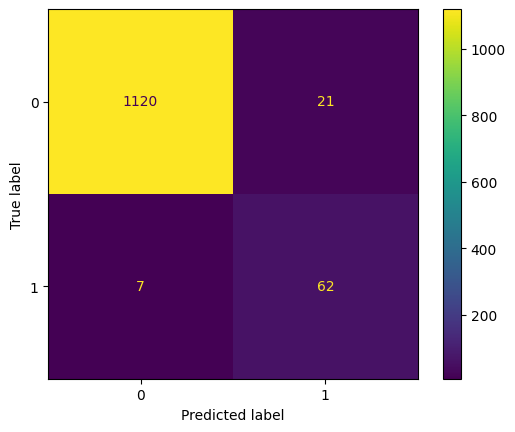

In [71]:
# --- SVM après SMOTE ---
print("Résultats pour SVM avec SMOTE :")
print(classification_report(y_test, svm_predictions))

cm_svm_smote = confusion_matrix(y_test, svm_predictions)
print("Matrice de confusion - SVM SMOTE :")
ConfusionMatrixDisplay(cm_svm_smote).plot()
plt.show()

Pour les deux modèles, on observe une amélioration après l'application de SMOTE : le Gradient Boosting parvient mieux à prédire la classe 2 qu'auparavant, tandis que le SVM améliore ses performances sur la classe 1.
En revanche, lorsqu'on compare directement le GB_SMOTE et le SVM_SMOTE, leurs résultats sont globalement très similaires.

Je vais opter pour le modèle svm_model_smote, qui présente légèrement de meilleures performances.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Création d'un pipeline pour inclure SMOTE et le SVM
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(random_state=42))
])

# Définition des paramètres à tester pour le SVM
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  # Paramètre de régularisation
    'svm__kernel': ['linear', 'rbf'],  # Types de noyaux
    'svm__gamma': ['scale', 'auto'],  # Paramètre du noyau
    'svm__class_weight': ['balanced', None]  # Gestion du déséquilibre des classes
}

# GridSearchCV avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score d'exactitude : {grid_search.best_score_}")

# Prédiction sur les données de test
y_pred_tuned = grid_search.predict(X_test)

# Affichage du rapport de classification pour évaluer les performances du modèle
print(classification_report(y_test, y_pred_tuned))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Meilleurs paramètres : {'svm__C': 100, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Meilleur score d'exactitude : 0.982635508691935
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      1141
           2       0.79      0.88      0.84        69

    accuracy                           0.98      1210
   macro avg       0.89      0.94      0.91      1210
weighted avg       0.98      0.98      0.98      1210



## 4) INTERPRETATION

In [ ]:
Je vais opter pour le modèle svm_model_smote, qui présente légèrement de meilleures performances.

### GLOBAL (PFI PDP)

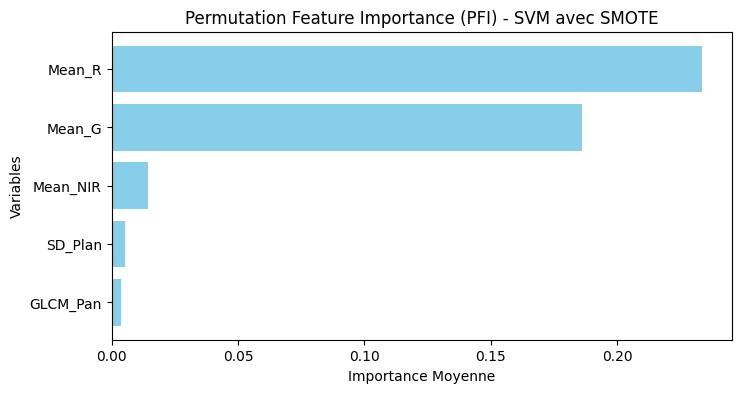

In [61]:
# PFI

from sklearn.inspection import permutation_importance

# Récupérer les importances permutées sur le modèle SVM avec SMOTE
result = permutation_importance(svm_model_smote, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Récupération des importances moyennes
importances = result.importances_mean

# Si X_test est un DataFrame, on récupère les noms des features
feature_names = X_test.columns

# Tri des indices par importance croissante
sorted_idx = np.argsort(importances)

# Affichage sous forme de barres horizontales
plt.figure(figsize=(8, 4))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel("Importance Moyenne")
plt.ylabel("Variables")
plt.title("Permutation Feature Importance (PFI) - SVM avec SMOTE")
plt.show()

J'utilise le PDP pour les 3 variables les plus importantes selon le PFI.

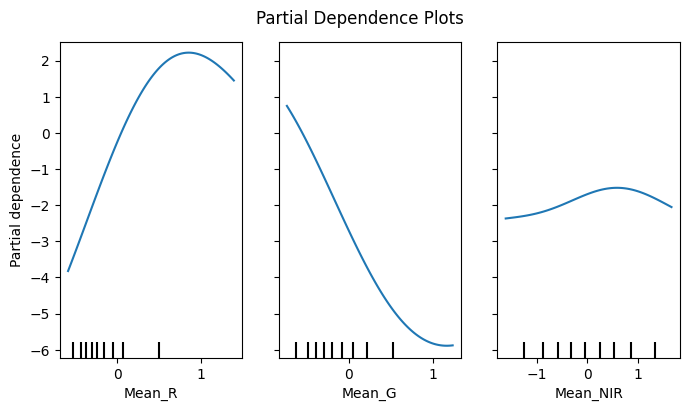

In [63]:
# PDP

from sklearn.inspection import PartialDependenceDisplay

# Partial Dependence Plots (PDP)
features_to_plot = ['Mean_R', 'Mean_G','Mean_NIR']
fig, ax = plt.subplots(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(svm_model_smote, X_train, features_to_plot, ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)
plt.show()

- Mean_R : Plus la moyenne de la valeur de la bande rouge augmente et plus la probabilité que l'observation soit classée comme "arbre malade" augmente.
- Mean_G : c'est l'exact opposé. Plus la moyenne de la valeur de la bande verte baisse et plus la probabilité que l'observation soit classée comme "arbre malade" augmente.
- Mean_NIR : Pas vraiment d'effet.

Explications : 

Mean_R : La bande rouge capture principalement la lumière absorbée par la chlorophylle des plantes. Les plantes saines, par exemple, absorbent beaucoup de lumière dans la bande rouge, ce qui fait que la réflexion dans cette bande est faible. En revanche, les plantes malades peuvent avoir un comportement différent, souvent une réflexion plus élevée dans cette bande en raison de modifications dans leur structure cellulaire et leur composition chimique. C'est pourquoi un augmentation de la moyenne dans la bande rouge pourrait indiquer un arbre malade.

Mean_G: La bande verte est également importante pour observer la santé des plantes, mais elle est moins sensible à l'absorption par la chlorophylle. Les plantes saines réfléchissent plus de lumière dans cette bande, tandis que les plantes malades peuvent perdre cette capacité de réflexion en raison de la dégradation des tissus végétaux (d'où une valeur plus basse dans cette bande). Ainsi, un réduit de la moyenne dans la bande verte pourrait être un signe de végétation en mauvaise santé, comme des arbres malades.

Mean_NIR : La bande infrarouge est souvent très utile pour détecter la végétation, et dans de nombreux cas, elle est fortement corrélée avec la santé de la végétation. Cependant, comme les autres variables (bande rouge et verte) capturent déjà bien cette information dans le modèle, alors l'impact direct de cette bande est faible.

### LOCAL (ICE)

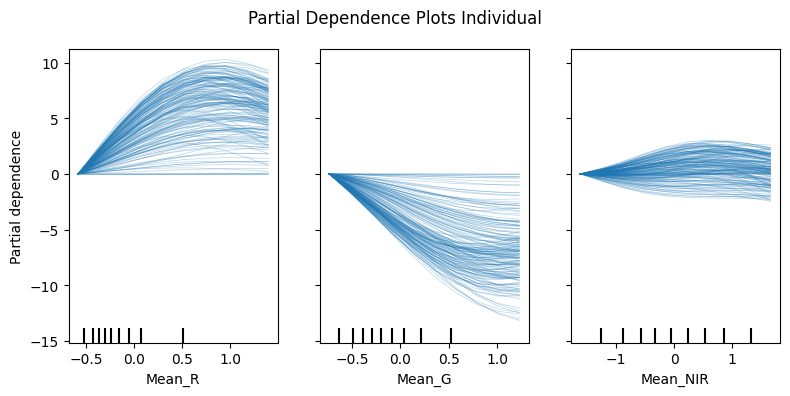

In [65]:
# ICE

# Création de la figure
fig, ax1 = plt.subplots(figsize=(8, 4))

# Affichage des PDP et ICE
PartialDependenceDisplay.from_estimator(svm_model_smote,  
                                         X_train, 
                                         features_to_plot,
                                         kind="individual",
                                         ax=ax1,
                                         grid_resolution=10,
                                         n_cols=3,
                                         subsample=0.05,
                                         centered=True
                                         )

plt.suptitle("Partial Dependence Plots Individual")
plt.tight_layout()
plt.show()

Résultats logiques : On observe plus de variation dans les PDPI de Mean_G et Mean_R, ce qui signifie que ces variables sont plus discriminantes et influencent davantage le modèle.